In [1]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from tqdm import tqdm
tqdm.pandas()

import umap.umap_ as umap
import umap.plot
import umap.utils as utils
import umap.aligned_umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint

from padelpy import from_smiles
import pubchempy as pcp

tqdm.pandas()

/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:

def create_manifold(
    df: pd.DataFrame, 
    n_components: int,
    n_neighbors: int, 
    min_dist: float,
    metric: str,
    random_state: int,
    target_weight: float,
    supervised: bool,
) -> Tuple[umap.umap_.UMAP, np.ndarray]:
    x, y, y_str = df.drop(["label", "label_str"], axis=1), df[["label"]].values.flatten(), df[["label_str"]].values.flatten()
    y_encoded = pd.factorize(y)[0]
    if supervised:
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
            target_weight=target_weight,
        ).fit(x, y_encoded)
    else: 
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
        ).fit(x)
    return manifold, y_str


def create_dfs_from_final_and_removed(df_final: pd.DataFrame, df_removed: pd.DataFrame, final: bool) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    df_final = convert_to_maccs_fingerprints(df=df_final)
    df_removed = convert_to_maccs_fingerprints(df=df_removed)
    
    if final: 
        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"
    else: 
        curated = "$Curated_{BIOWIN}$"
        removed = "$Curated_{Problematic}$"
    cols = [*range(0, 167, 1)]
    df_final_fp = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)
    # Create scs labeled with removed and kept
    df_final_fp["label"] = curated
    df_removed_fp["label"] = removed
    df_scs_removed_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_removed_labels["label_str"] = df_scs_removed_labels['label']

    # Create scs labeled with two labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels["label_str"] = df_scs_two_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # Create scs labeled with four labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label'] + 2
    df_scs_four_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_four_labels["label_str"] = df_scs_four_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB", 2: f"{removed} NRB", 3: f"{removed} RB"})

    # Create scs labeled with two labels four colors
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels_four_colors = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels_four_colors["label_str"] = df_scs_four_labels['label_str']

    # Create final labeled with RB and NRB
    df_final_fp_labeled = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_final_fp_labeled["label"] = df_final["label"]
    df_final_fp_labeled["label_str"] = df_final_fp_labeled['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # semisupervised
    df_removed_fp["label"] = -1
    df_scs_semi_supervised = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_semi_supervised["label_str"] = df_scs_four_labels['label_str']

    return df_scs_removed_labels, df_scs_two_labels, df_scs_four_labels, df_scs_two_labels_four_colors, df_final_fp_labeled, df_scs_semi_supervised



def create_dfs_for_umap_before_readding() -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    df_final = pd.read_csv("datasets/old_data/class_improved_env_biowin_both.csv", index_col=0)
    df_final = df_final[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label']]
    df_final.reset_index(inplace=True, drop=True)
    df_removed = pd.read_csv("datasets/old_data/class_improved_env_biowin_both_removed_predicted.csv", index_col=0)
    df_removed.reset_index(inplace=True, drop=True)

    return create_dfs_from_final_and_removed(df_final, df_removed, final=False)


def create_dfs_for_umap() -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    df_final = pd.read_csv("datasets/old_data/class_improved_env_biowin_both_readded.csv", index_col=0)
    df_final = df_final[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label',
        'prediction_class']]
    df_final.reset_index(inplace=True, drop=True)
    df_removed = pd.read_csv("datasets/old_data/class_improved_env_biowin_both_removed_predicted.csv", index_col=0)
    df_removed = df_removed[df_removed["label"] != df_removed["prediction_class"]]
    df_removed.reset_index(inplace=True, drop=True)

    return create_dfs_from_final_and_removed(df_final, df_removed, final=True)


def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
    number_of_labels: List[int],
    figure_title: str,
    final: List[bool],
) -> None:

    num_plots = len(manifolds)
    rows_of_plots = int(num_plots/2)
    fig, axs = plt.subplots(2, 3, figsize=(30, 20))

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]
        final_cur = final[i]

        if final_cur: 
            curated = "$Curated_{Final}$"
            removed = "$Curated_{Removed}$"
        else: 
            curated = "$Curated_{BIOWIN}$"
            removed = "$Curated_{Problematic}$"
    


        if ('NRB' in label[0]) | ('RB' in label[0]):
            color_key={
                f"{curated} NRB": 'royalblue', 
                f"{removed} NRB": 'limegreen', 
                f"{curated} RB": 'darkorange', 
                f"{removed} RB": 'fuchsia'} 
        else: 
            if final_cur:
                color_key={
                    curated: 'green', 
                    removed: 'gold'}
            else: 
                color_key={
                    curated: 'forestgreen', 
                    removed: 'yellow'}
        umap.plot.points(
            umap_object=manifolds[i], 
            labels=label, 
            color_key=color_key,
            background='black',
            ax=ax,
        ) 
        ax.set_xlabel(titles[i], fontsize=22)
        nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
        rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
        if number_of_labels[i] == 4:
            nrb_r = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
            rb_r = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
            ax.legend(loc=legend_loc[i], handles=[nrb, rb, nrb_r, rb_r], fontsize=16)
        elif ('NRB' not in label[0]) & ('RB' not in label[0]):
            if final_cur:
                cb = mpatches.Patch(color='green', label=curated)
                cr = mpatches.Patch(color='gold', label=removed)
            else: 
                cb = mpatches.Patch(color='forestgreen', label=curated)
                cr = mpatches.Patch(color='yellow', label=removed)
            ax.legend(loc=legend_loc[i], handles=[cb, cr], fontsize=16)
        else:
            ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=16)
        umap.plot.plt.savefig(f'figures/{figure_title}.png')


## Unsupervised and semisupervised before readding

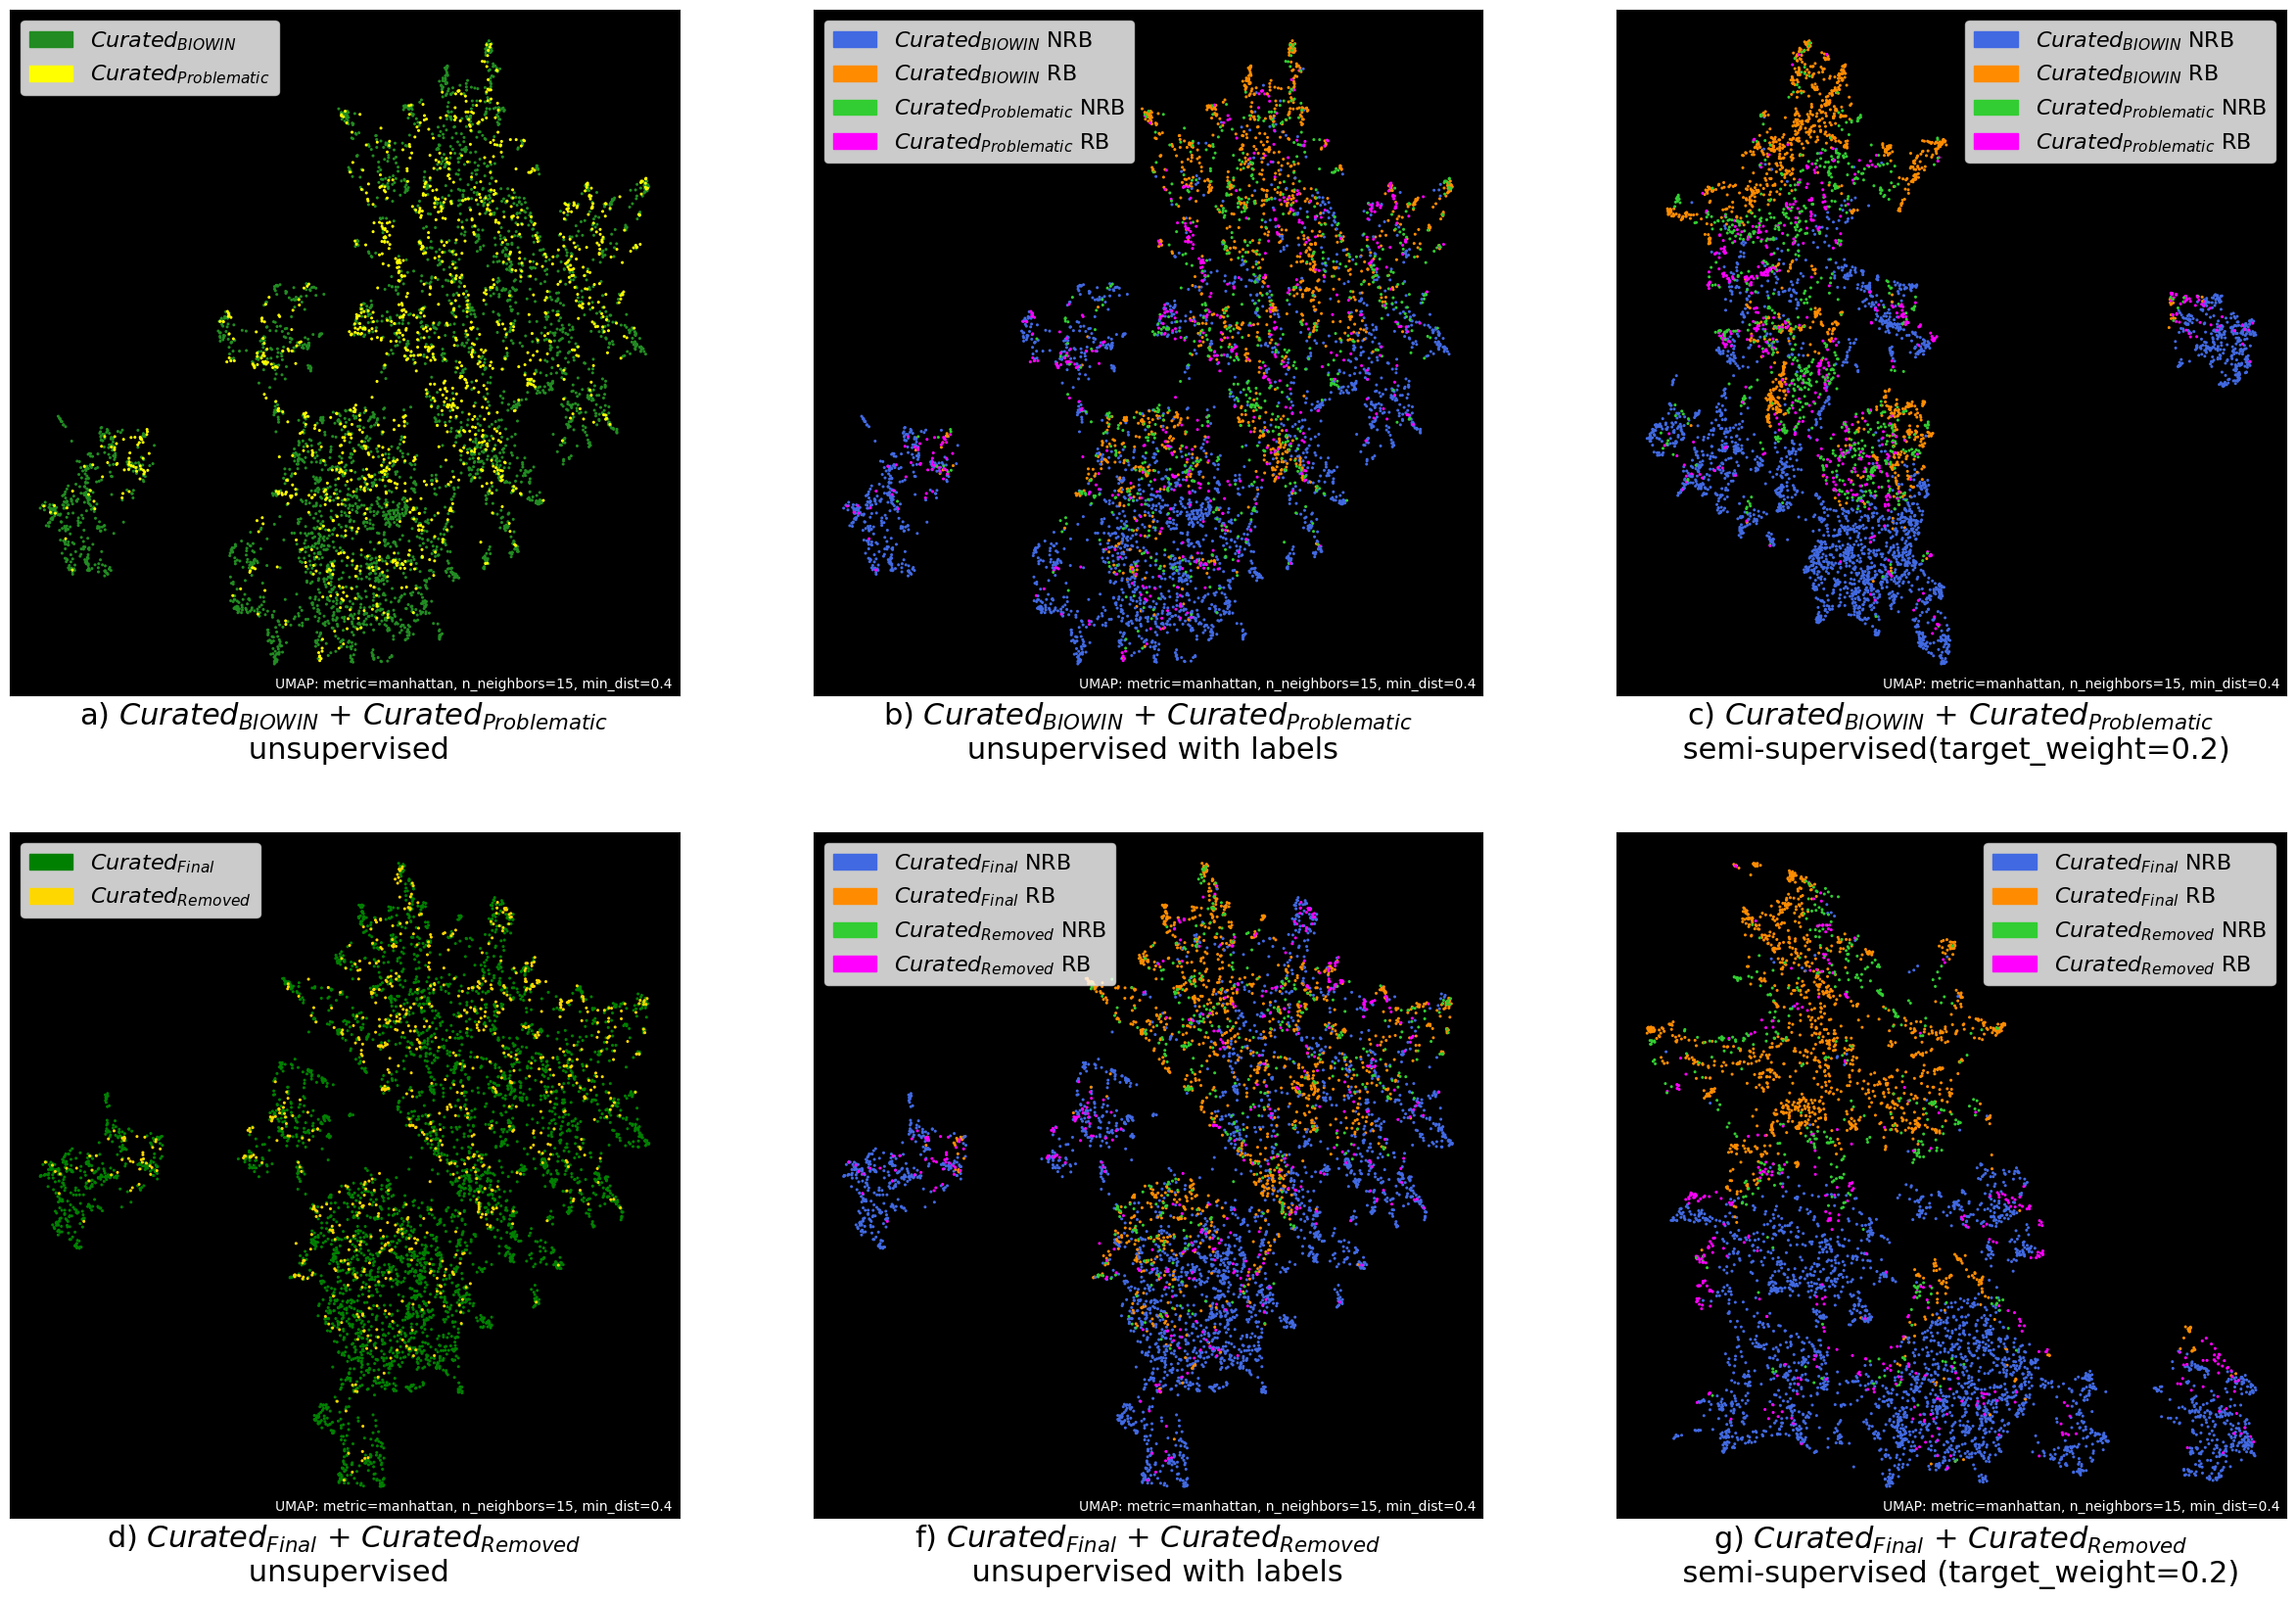

In [3]:
def create_plot_umap_semisupervised(
    n_components, 
    n_neighbors, 
    min_dist, 
    target_weight, 
    metric, 
    random_state
) -> None:

    # Biowin
    df_scs_removed_labels, _, df_scs_four_labels, _, _, df_scs_semi_supervised = create_dfs_for_umap_before_readding()

    manifold_unsupervised_removed, y_unsupervised_str_removed = create_manifold(
        df=df_scs_removed_labels, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_unsupervised, y_unsupervised_str = create_manifold(
        df=df_scs_four_labels, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_semi_supervised, y_semi_supervised_str = create_manifold(
        df=df_scs_semi_supervised, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )

    # Final
    df_scs_removed_labels_final, _, df_scs_four_labels_final, _, _, df_scs_semi_supervised_final = create_dfs_for_umap()

    manifold_unsupervised_removed_final, y_unsupervised_str_removed_final = create_manifold(
        df=df_scs_removed_labels_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_unsupervised_final, y_unsupervised_str_final = create_manifold(
        df=df_scs_four_labels_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_semi_supervised_final, y_semi_supervised_str_final = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )

    # Create plot
    manifolds = [
        manifold_unsupervised_removed,
        manifold_unsupervised,
        manifold_semi_supervised, 
        manifold_unsupervised_removed_final,
        manifold_unsupervised_final,
        manifold_semi_supervised_final 
    ]
    y_strs = [
        y_unsupervised_str_removed,
        y_unsupervised_str,
        y_semi_supervised_str,
        y_unsupervised_str_removed_final,
        y_unsupervised_str_final,
        y_semi_supervised_str_final,
    ]

    titles = [
        'a) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n unsupervised',
        'b) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n unsupervised with labels',
        'c) $Curated_{BIOWIN}$ + $Curated_{Problematic}$ \n semi-supervised' + f'(target_weight={target_weight})',
        'd) $Curated_{Final}$ + $Curated_{Removed}$ \n unsupervised',
        'f) $Curated_{Final}$ + $Curated_{Removed}$ \n  unsupervised with labels',
        'g) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised ' + f'(target_weight={target_weight})',
    ]
    legend_loc = [
        'upper left',
        'upper left',
        'upper right',
        'upper left',
        'upper left',
        'upper right',
    ]
    number_of_labels = [2, 4, 4, 2, 4, 4]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
        number_of_labels=number_of_labels,
        figure_title="umap_semisupervised",
        final=[False, False, False, True, True, True]
    )

create_plot_umap_semisupervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
)

## Fit on final and transform removed

In [8]:
def create_plots_fit_transform(n_components, n_neighbors, min_dist, target_weight, metric, random_state):
    df_final = pd.read_csv("datasets/curated_data/class_curated_scs_biowin_readded.csv", index_col=0)
    df_final = df_final[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label',
        'prediction_class']]
    df_final.reset_index(inplace=True, drop=True)
    df_removed = pd.read_csv("datasets/curated_data/class_curated_scs_biowin_removed_predicted.csv", index_col=0)
    df_removed = df_removed[df_removed["label"] != df_removed["prediction_class"]]
    df_removed.reset_index(inplace=True, drop=True)

    def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    df_final = convert_to_maccs_fingerprints(df=df_final)
    df_removed = convert_to_maccs_fingerprints(df=df_removed)

    cols = [*range(0, 167, 1)]

    df_final_fp = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_final_fp["label"] = df_final["label"]
    df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)

    # final 
    df_final_data = df_final_fp.copy()
    df_final_data["label_str"] = df_final_data['label'].map({0: "NRB", 1: "RB"})

    # removed
    df_removed_data = df_removed_fp.copy()
    df_removed_data["label"] = df_removed["label"]
    df_removed_data["label_str"] = df_removed_data['label'].map({0: "NRB removed", 1: "RB removed"})


    # Fit final and then transform removed data
    x_final, y_final, y_final_str = df_final_data.drop(["label", "label_str"], axis=1), df_final_data[["label"]].values.flatten(), df_final_data[["label_str"]].values.flatten()
    manifold_final = umap.UMAP(
        n_components=n_components, 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric=metric, 
        random_state=random_state, 
        n_jobs=1,
        target_weight=target_weight,
    ).fit(x_final, y_final)

    # Transform removed 
    x_removed, _, y_removed_str = df_removed_data.drop(["label", "label_str"], axis=1), df_removed_data[["label"]].values.flatten(), df_removed_data[["label_str"]].values.flatten()
    manifold_fit_transform = manifold_final.transform(x_removed)

    manifolds_embeddings = [
        manifold_final.embedding_,
        manifold_fit_transform,
    ]
    y_strs = [
        y_final_str,
        y_removed_str,
    ]
    titles = [
        'a) 2D embeddings of the $Curated_{Final}$ data', #  + f'(target_weight={target_weight})'
        'b) Transformed $Removed$ data',
    ]

    legend_loc = [
        'lower right', # lower
        'lower right',
    ]

    for indx, y_str in enumerate(y_strs):
        for i in range(len(y_str)):
            if y_str[i] == "NRB":
                y_str[i] = 'royalblue'
            elif y_str[i] == "RB":
                y_str[i] = 'darkorange'
            elif y_str[i] == "NRB removed":
                y_str[i] = 'royalblue'
            elif y_str[i] == "RB removed":
                y_str[i] = 'darkorange'
        y_strs[indx] = y_str

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    for i, ax in enumerate(axs.flatten()):
        manifolds_embedding = manifolds_embeddings[i]
        ax.scatter(manifolds_embedding[:, 0], manifolds_embedding[:, 1], s=3, c=y_strs[i])
        ax.set_xlabel(titles[i], fontsize=22)
        ax.set_facecolor('black')
        if '$Curated_{Final}$' in titles[i]:
            nrb = mpatches.Patch(color='royalblue', label="NRB")
            rb = mpatches.Patch(color='darkorange', label="RB")
            ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=18) #, title="Classes"
        else: 
            nrbr = mpatches.Patch(color='royalblue', label="NRB removed")
            rbr = mpatches.Patch(color='darkorange', label="RB removed")
            ax.legend(loc=legend_loc[i], handles=[nrbr, rbr], fontsize=18) #, title="Classes"

n_components = 2
n_neighbors = 30
target_weight = 0.2
random_state=42

min_dist = 0.5
metric = "manhattan"

create_plots_fit_transform(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, target_weight=target_weight, metric=metric, random_state=random_state)

ValueError: Input contains NaN.

In [ ]:
# Analyse third cluster

df_embeddings_final = pd.read_csv("dataframes/embeddings_final.csv", index_col=0)
print(len(df_embeddings_final))
df_cluster = df_embeddings_final[(df_embeddings_final["x_value"] > 10.0) & (df_embeddings_final["y_value"] < 15.0)]
df_final = pd.read_csv("dataframes/improved_data/class_improved_env_biowin_both_readded.csv", index_col=0)
df_final_in_cluster = df_final[df_final.index.isin(df_cluster.index)]
print("Data points in cluster: ", len(df_final_in_cluster))
df_final_in_cluster_with_s = df_final_in_cluster[df_final_in_cluster['smiles'].str.contains("S")]
print("Percentage in cluster that contains S: ", len(df_final_in_cluster_with_s)/len(df_final_in_cluster)*100)
df_final_in_cluster_with_s_o = df_final_in_cluster_with_s[df_final_in_cluster_with_s['smiles'].str.contains("O")]
print("Percentage in cluster that contains S and O: ", len(df_final_in_cluster_with_s_o)/len(df_final_in_cluster)*100)
df_final_in_cluster_with_s_o_n = df_final_in_cluster_with_s_o[df_final_in_cluster_with_s_o['smiles'].str.contains("N")]
print("Percentage in cluster that contains S, O, and N: ", len(df_final_in_cluster_with_s_o_n)/len(df_final_in_cluster)*100)
def contains_ring(smiles):
    mol = Chem.MolFromSmiles(smiles)  # can use Chem.MolFromInchi for InChI strings
    num_rings = mol.GetRingInfo().NumRings()
    return num_rings
df_final_in_cluster_with_s_o['num_rings'] = df_final_in_cluster_with_s_o['smiles'].apply(contains_ring)
df_final_in_cluster_with_s_o_ring = df_final_in_cluster_with_s_o[df_final_in_cluster_with_s_o['num_rings']>0]
print("Percentage in cluster that contains S, O, and at least one ring: ", len(df_final_in_cluster_with_s_o_ring)/len(df_final_in_cluster)*100)
# all of the substances in the cluster are organosulfur compounds


df_final_not_in_cluster = df_final[~df_final.index.isin(df_cluster.index)]
print("Data points not in cluster: ", len(df_final_not_in_cluster))
df_final_not_in_cluster_with_s = df_final_not_in_cluster[df_final_not_in_cluster['smiles'].str.contains("S")]
print("Percentage not in cluster that contains S: ", len(df_final_not_in_cluster_with_s)/len(df_final_not_in_cluster)*100)
df_final_not_in_cluster_with_s_o = df_final_not_in_cluster[(df_final_not_in_cluster['smiles'].str.contains("O")) & (df_final_not_in_cluster['smiles'].str.contains("S"))]
print("Percentage not in cluster that contains S and O: ", len(df_final_not_in_cluster_with_s_o)/len(df_final_not_in_cluster)*100)
print("Number of organosulfur chemicals outside cluster: ", len(df_final_not_in_cluster_with_s_o))
print("Number of organosulfur chemicals outside cluster which are RB: ", len(df_final_not_in_cluster_with_s_o[df_final_not_in_cluster_with_s_o["label"]==1]))
df_final_not_in_cluster_o = df_final_not_in_cluster[(df_final_not_in_cluster['smiles'].str.contains("O"))]
print("Percentage not in cluster that contains O: ", len(df_final_not_in_cluster_o)/len(df_final_not_in_cluster)*100)
df_final_not_in_cluster_n = df_final_not_in_cluster[df_final_not_in_cluster['smiles'].str.contains("N")]
print("Percentage not in cluster that contains N: ", len(df_final_not_in_cluster_n)/len(df_final_not_in_cluster)*100)
def contains_ring(smiles):
    mol = Chem.MolFromSmiles(smiles)  # can use Chem.MolFromInchi for InChI strings
    num_rings = mol.GetRingInfo().NumRings()
    return num_rings
df_final_not_in_cluster['num_rings'] = df_final_not_in_cluster['smiles'].apply(contains_ring)
df_final_not_in_cluster_ring = df_final_not_in_cluster[df_final_not_in_cluster['num_rings']>0]
print("Percentage not in cluster that contains at least one ring: ", len(df_final_not_in_cluster_ring)/len(df_final_not_in_cluster)*100)
df_final_not_in_cluster_with_s_o['num_rings'] = df_final_not_in_cluster_with_s_o['smiles'].apply(contains_ring)
df_final_not_in_cluster_with_s_o_ring = df_final_not_in_cluster_with_s_o[df_final_not_in_cluster_with_s_o['num_rings']>0]
print("Percentage in cluster that contains S, O, and at least one ring: ", len(df_final_not_in_cluster_with_s_o_ring)/len(df_final_not_in_cluster)*100)


rb_in_luster = df_final_in_cluster[df_final_in_cluster["label"]==1]
print(len(rb_in_luster))

## Other fingerprints

In [14]:

def create_manifold(
    df: pd.DataFrame, 
    n_components: int,
    n_neighbors: int, 
    min_dist: float,
    metric: str,
    random_state: int,
    target_weight: float,
    supervised: bool,
) -> Tuple[umap.umap_.UMAP, np.ndarray]:
    x, y, y_str = df.drop(["label", "label_str"], axis=1), df[["label"]].values.flatten(), df[["label_str"]].values.flatten()
    # y_encoded = pd.factorize(y)[0] # TODO
    print(np.unique(y)) #y_encoded
    if supervised:
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
            target_weight=target_weight,
        ).fit(x, y) #y_encoded
    else: 
        manifold = umap.UMAP(
            n_components=n_components, 
            n_neighbors=n_neighbors, 
            min_dist=min_dist, 
            metric=metric, 
            random_state=random_state, 
            n_jobs=1,
        ).fit(x)
    return manifold, y_str


def create_dfs_from_final_and_removed(df_final: pd.DataFrame, df_removed: pd.DataFrame, final: bool, fp_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    def convert_to_rdk_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        # calculate 2048 bit RDK fingerprint
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [Chem.RDKFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    def convert_to_pubchem_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        # calculate 881 bit PubChem fingerprint
        def get_pubchem_fp_padel(row) -> np.ndarray:
            smiles = row["smiles"]
            try:
                fingerprint_dict = from_smiles(smiles, fingerprints=True, descriptors=False)
            except: 
                print("Error when retrieving PubChem FP for SMILES ", smiles)
                return None
            fp = [int(bit) for bit in fingerprint_dict.values()]
            return fp
        
        df["fingerprint"] = df.progress_apply(get_pubchem_fp_padel, axis=1).to_list()
        df = df[df["fingerprint"] != None]
        return df

    if fp_type=="rdk":
        size = 2048
        df_final = convert_to_rdk_fingerprints(df=df_final)
        df_removed = convert_to_rdk_fingerprints(df=df_removed)
    elif fp_type=="maccs":
        size = 167
        df_final = convert_to_maccs_fingerprints(df=df_final)
        df_removed = convert_to_maccs_fingerprints(df=df_removed)
    elif fp_type=="pubchem":
        size = 881
        new = False # TODO
        if new:
            df_final = convert_to_pubchem_fingerprints(df=df_final)
            df_final.to_csv("datasets/different_features/df_final_pubchem_fingerprints.csv")
            df_removed = convert_to_pubchem_fingerprints(df=df_removed)
            df_removed.to_csv("datasets/different_features/df_removed_pubchem_fingerprints.csv")
        else:
            df_final = pd.read_csv("datasets/different_features/df_final_pubchem_fingerprints.csv", index_col=0)
            df_final = df_final.dropna(subset=['fingerprint'], how='any', ignore_index=True)
            df_final['fingerprint'] = df_final['fingerprint'].apply(lambda x: [int(val) if val != 'nan' else np.nan for val in str(x).strip('[]').split()])

            df_removed = pd.read_csv("datasets/different_features/df_removed_pubchem_fingerprints.csv", index_col=0)
            df_removed = df_removed.dropna(subset=['fingerprint'], how='any', ignore_index=True)
            df_removed['fingerprint'] = df_removed['fingerprint'].apply(lambda x: [int(val) if val != 'nan' else np.nan for val in str(x).strip('[]').split()])


    elif fp_type=="molformer":
        size = 768
        df_final = pd.read_csv("datasets/different_features/df_final_molformer_embeddings.csv", index_col=0)
        df_final['fingerprint'] = df_final['fingerprint'].apply(eval)
        df_removed = pd.read_csv("datasets/different_features/df_removed_molformer_embeddings.csv", index_col=0)
        df_removed['fingerprint'] = df_removed['fingerprint'].apply(eval)
    
    if final: 
        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"
    else: 
        curated = "$Curated_{BIOWIN}$"
        removed = "$Curated_{Problematic}$"

    cols = [*range(0, size, 1)] 
    df_final_fp = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)
    # Create scs labeled with removed and kept
    df_final_fp["label"] = curated
    df_removed_fp["label"] = removed
    df_scs_removed_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_removed_labels.reset_index(inplace=True, drop=True)
    df_scs_removed_labels["label_str"] = df_scs_removed_labels['label']

    # Create scs labeled with two labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels.reset_index(inplace=True, drop=True)
    df_scs_two_labels["label_str"] = df_scs_two_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # Create scs labeled with four labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label'] + 2
    df_scs_four_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_four_labels.reset_index(inplace=True, drop=True)
    df_scs_four_labels["label_str"] = df_scs_four_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB", 2: f"{removed} NRB", 3: f"{removed} RB"})

    # Create scs labeled with two labels four colors
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels_four_colors = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels_four_colors.reset_index(inplace=True, drop=True)
    df_scs_two_labels_four_colors["label_str"] = df_scs_four_labels['label_str']

    # Create final labeled with RB and NRB
    df_final_fp_labeled = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_final_fp_labeled["label"] = df_final["label"]
    df_final_fp_labeled["label_str"] = df_final_fp_labeled['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # semisupervised
    df_removed_fp["label"] = -1
    df_scs_semi_supervised = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_semi_supervised.reset_index(inplace=True, drop=True)
    df_scs_semi_supervised["label_str"] = df_scs_four_labels['label_str']

    # final 
    df_final_data = df_final_fp.copy()
    df_final_data["label_str"] = df_final_data['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # removed
    df_removed_data = df_removed_fp.copy()
    df_removed_data["label"] = df_removed["label"]
    df_removed_data["label_str"] = df_removed_data['label'].map({0: f"{removed} NRB", 1: f"{removed} RB"})

    return df_final_data, df_removed_data, df_scs_removed_labels, df_scs_two_labels, df_scs_four_labels, df_scs_two_labels_four_colors, df_final_fp_labeled, df_scs_semi_supervised


def create_dfs_for_umap_different_features(fp_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    df = pd.read_csv("datasets/curated_data/class_curated_scs.csv", index_col=0)

    df_final = pd.read_csv("datasets/curated_data/class_curated_scs_biowin_readded.csv", index_col=0)
    df_final = df_final[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
        'non_linear_label', 'miti_linear_label', 'miti_non_linear_label',
        'prediction_class']]
    df_final.reset_index(inplace=True, drop=True)
    df_removed = pd.read_csv("datasets/curated_data/class_curated_scs_biowin_readded_removed_predicted.csv", index_col=0)
    df_removed.reset_index(inplace=True, drop=True)

    print(len(df))
    print(len(df_final))
    print(len(df_removed))
    assert len(df) == len(df_final) + len(df_removed)

    return create_dfs_from_final_and_removed(df_final, df_removed, final=True, fp_type=fp_type)


def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
    number_of_labels: List[int],
    figure_title: str,
    final: List[bool],
) -> None:

    fig, axs = plt.subplots(2, 2, figsize=(20, 20)) #(Suplots: rows, cols -> 3, 2), figsize = (20,30)

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]
        final_cur = final[i]

        if final_cur: 
            curated = "$Curated_{Final}$"
            removed = "$Curated_{Removed}$"
        else: 
            curated = "$Curated_{BIOWIN}$"
            removed = "$Curated_{Problematic}$"

        if i <= 1:
            if ('NRB' in label[0]) | ('RB' in label[0]):
                color_key={
                    f"{curated} NRB": 'royalblue', 
                    f"{removed} NRB": 'limegreen', 
                    f"{curated} RB": 'darkorange', 
                    f"{removed} RB": 'fuchsia'} 
            else: 
                if final_cur:
                    color_key={
                        curated: 'green', 
                        removed: 'gold'}
                else: 
                    color_key={
                        curated: 'forestgreen', 
                        removed: 'yellow'}
            umap.plot.points(
                umap_object=manifolds[i], 
                labels=label, 
                color_key=color_key,
                background='black',
                ax=ax,
            ) 
            ax.set_xlabel(titles[i], fontsize=22)
            nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
            rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
            if number_of_labels[i] == 4:
                nrb_r = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
                rb_r = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
                ax.legend(loc=legend_loc[i], handles=[nrb, rb, nrb_r, rb_r], fontsize=16)
            elif ('NRB' not in label[0]) & ('RB' not in label[0]):
                if final_cur:
                    cb = mpatches.Patch(color='green', label=curated)
                    cr = mpatches.Patch(color='gold', label=removed)
                else: 
                    cb = mpatches.Patch(color='forestgreen', label=curated)
                    cr = mpatches.Patch(color='yellow', label=removed)
                ax.legend(loc=legend_loc[i], handles=[cb, cr], fontsize=16)
            else:
                ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=16)

        elif i > 1:
            for indx in range(len(label)):
                if label[indx] == f"{curated} NRB":
                    label[indx] = 'royalblue'
                elif label[indx] == f"{curated} RB":
                    label[indx] = 'darkorange'
                elif label[indx] == f"{removed} NRB":
                    label[indx] = 'limegreen'
                elif label[indx] == f"{removed} RB":
                    label[indx] = 'fuchsia'
            
            manifolds_embedding = manifolds[i]
            ax.scatter(manifolds_embedding[:, 0], manifolds_embedding[:, 1], s=3, c=label)
            ax.set_xlabel(titles[i], fontsize=22)
            ax.set_facecolor('black')
            if '$Curated_{Final}$' in titles[i]:
                nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
                rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
                ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=18) #, title="Classes"
            else: 
                nrbr = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
                rbr = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
                ax.legend(loc=legend_loc[i], handles=[nrbr, rbr], fontsize=18) #, title="Classes"


In [15]:
def create_plot_umap_different_features(
    n_components, 
    n_neighbors, 
    min_dist, 
    target_weight, 
    metric, 
    random_state,
    fp_type,
) -> None:

    # Final
    df_final, df_removed, df_scs_removed_labels, _, df_scs_four_labels, df_scs_two_labels_four_colors, _, df_scs_semi_supervised_final = create_dfs_for_umap_different_features(fp_type)

    # manifold_unsupervised_removed, y_str_unsupervised_removed = create_manifold(
    #     df=df_scs_removed_labels, 
    #     n_components=n_components,
    #     n_neighbors=n_neighbors, 
    #     min_dist=min_dist,
    #     metric=metric,
    #     random_state=random_state,
    #     target_weight=target_weight,
    #     supervised=False,
    # )
    manifold_unsupervised, y_str_unsupervised = create_manifold(
        df=df_scs_four_labels, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=False,
    )
    manifold_semi_supervised, y_str_semi_supervised = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=target_weight,
        supervised=True,
    )
    # manifold_supervised, y_str_supervised = create_manifold(
    #     df=df_scs_four_labels, 
    #     n_components=n_components,
    #     n_neighbors=n_neighbors, 
    #     min_dist=min_dist,
    #     metric=metric,
    #     random_state=random_state,
    #     target_weight=target_weight,
    #     supervised=True,
    # )

    # Fit final and then transform removed data
    x_final, y_final, y_final_str = df_final.drop(["label", "label_str"], axis=1), df_final[["label"]].values.flatten(), df_final[["label_str"]].values.flatten()
    
    manifold_final = umap.UMAP(
        n_components=n_components, 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric=metric, 
        random_state=random_state, 
        n_jobs=1,
        target_weight=target_weight,
    ).fit(x_final, y_final)
    # Transform removed 
    x_removed, _, y_removed_str = df_removed.drop(["label", "label_str"], axis=1), df_removed[["label"]].values.flatten(), df_removed[["label_str"]].values.flatten()
    manifold_fit_transform = manifold_final.transform(x_removed)


    # Create plot
    manifolds = [
        # manifold_unsupervised_removed,
        manifold_unsupervised,
        manifold_semi_supervised,
        # manifold_supervised,
        manifold_final.embedding_,
        manifold_fit_transform,
    ]
    y_strs = [
        # y_str_unsupervised_removed,
        y_str_unsupervised,
        y_str_semi_supervised,
        # y_str_supervised,
        y_final_str,
        y_removed_str,
    ]

    titles = [
        # 'a) $Curated_{Final}$ + $Curated_{Removed}$ \n unsupervised',
        'a) $Curated_{Final}$ + $Curated_{Removed}$ \n  unsupervised with labels',
        'b) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised ' + f'(target_weight={target_weight})',
        # 'd) $Curated_{Final}$ + $Curated_{Removed}$ \n  supervised ' + f'(target_weight={target_weight})',
        'c) 2D embeddings of the $Curated_{Final}$ data', #  + f'(target_weight={target_weight})'
        'd) Transformed $Removed$ data',
    ]
    legend_loc = [
        # 'upper left',
        'upper left',
        'upper right',
        # 'upper right',
        'upper right',
        'upper right',
    ]
    number_of_labels = [4, 4, 4, 4]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
        number_of_labels=number_of_labels,
        figure_title="umap_semisupervised",
        final=[True, True, True, True]
    )


In [16]:
create_plot_umap_different_features(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
    fp_type="pubchem"
)

5017
4075
684


AssertionError: 

[0 1 2 3]
[-1  0  1]


/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


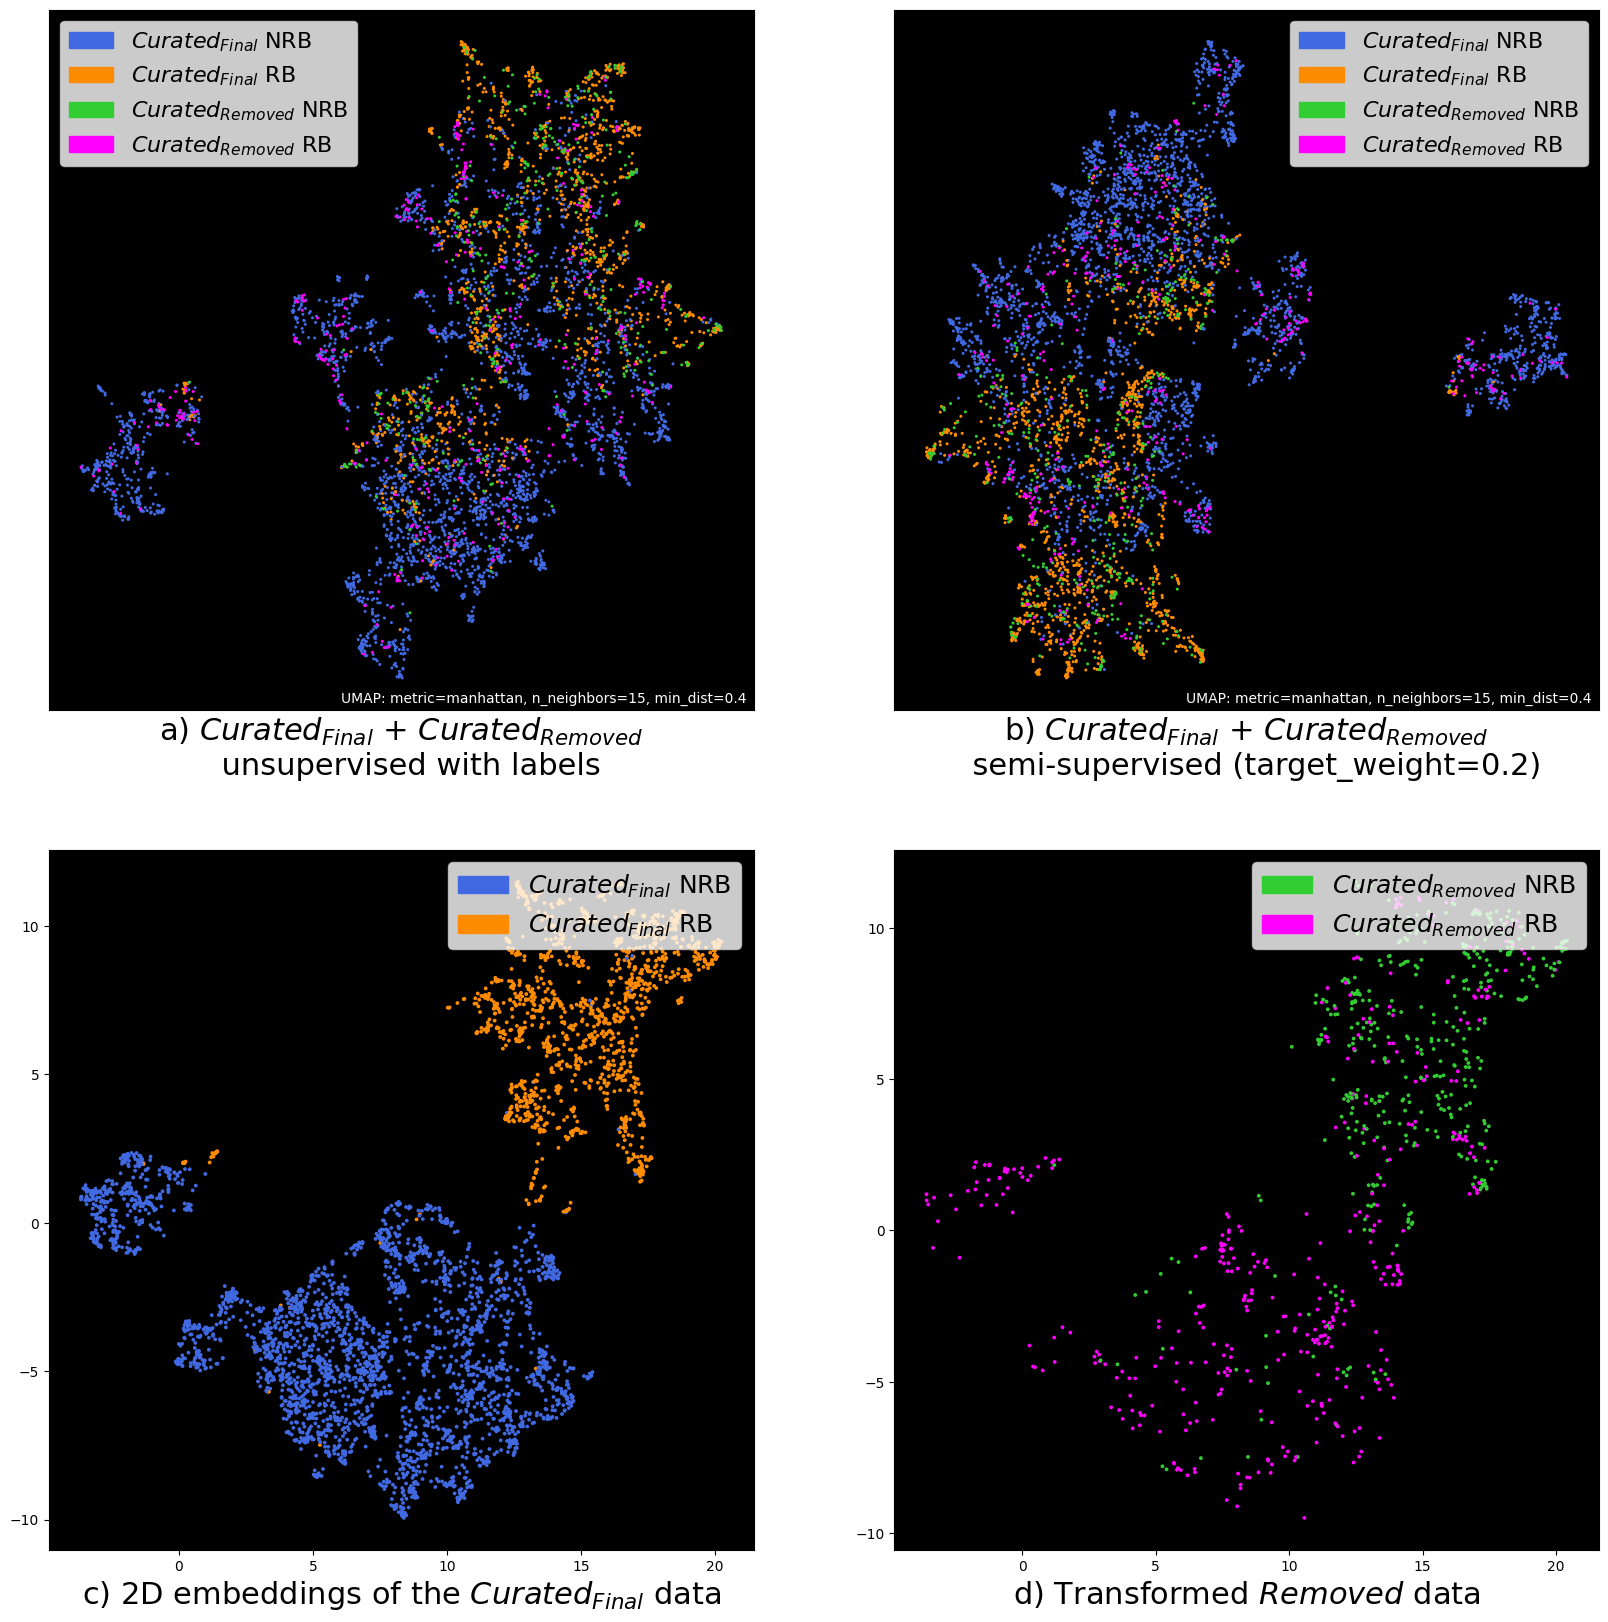

In [ ]:
create_plot_umap_different_features(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
    fp_type="maccs"
)

[0 1 2 3]
[-1  0  1]


/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


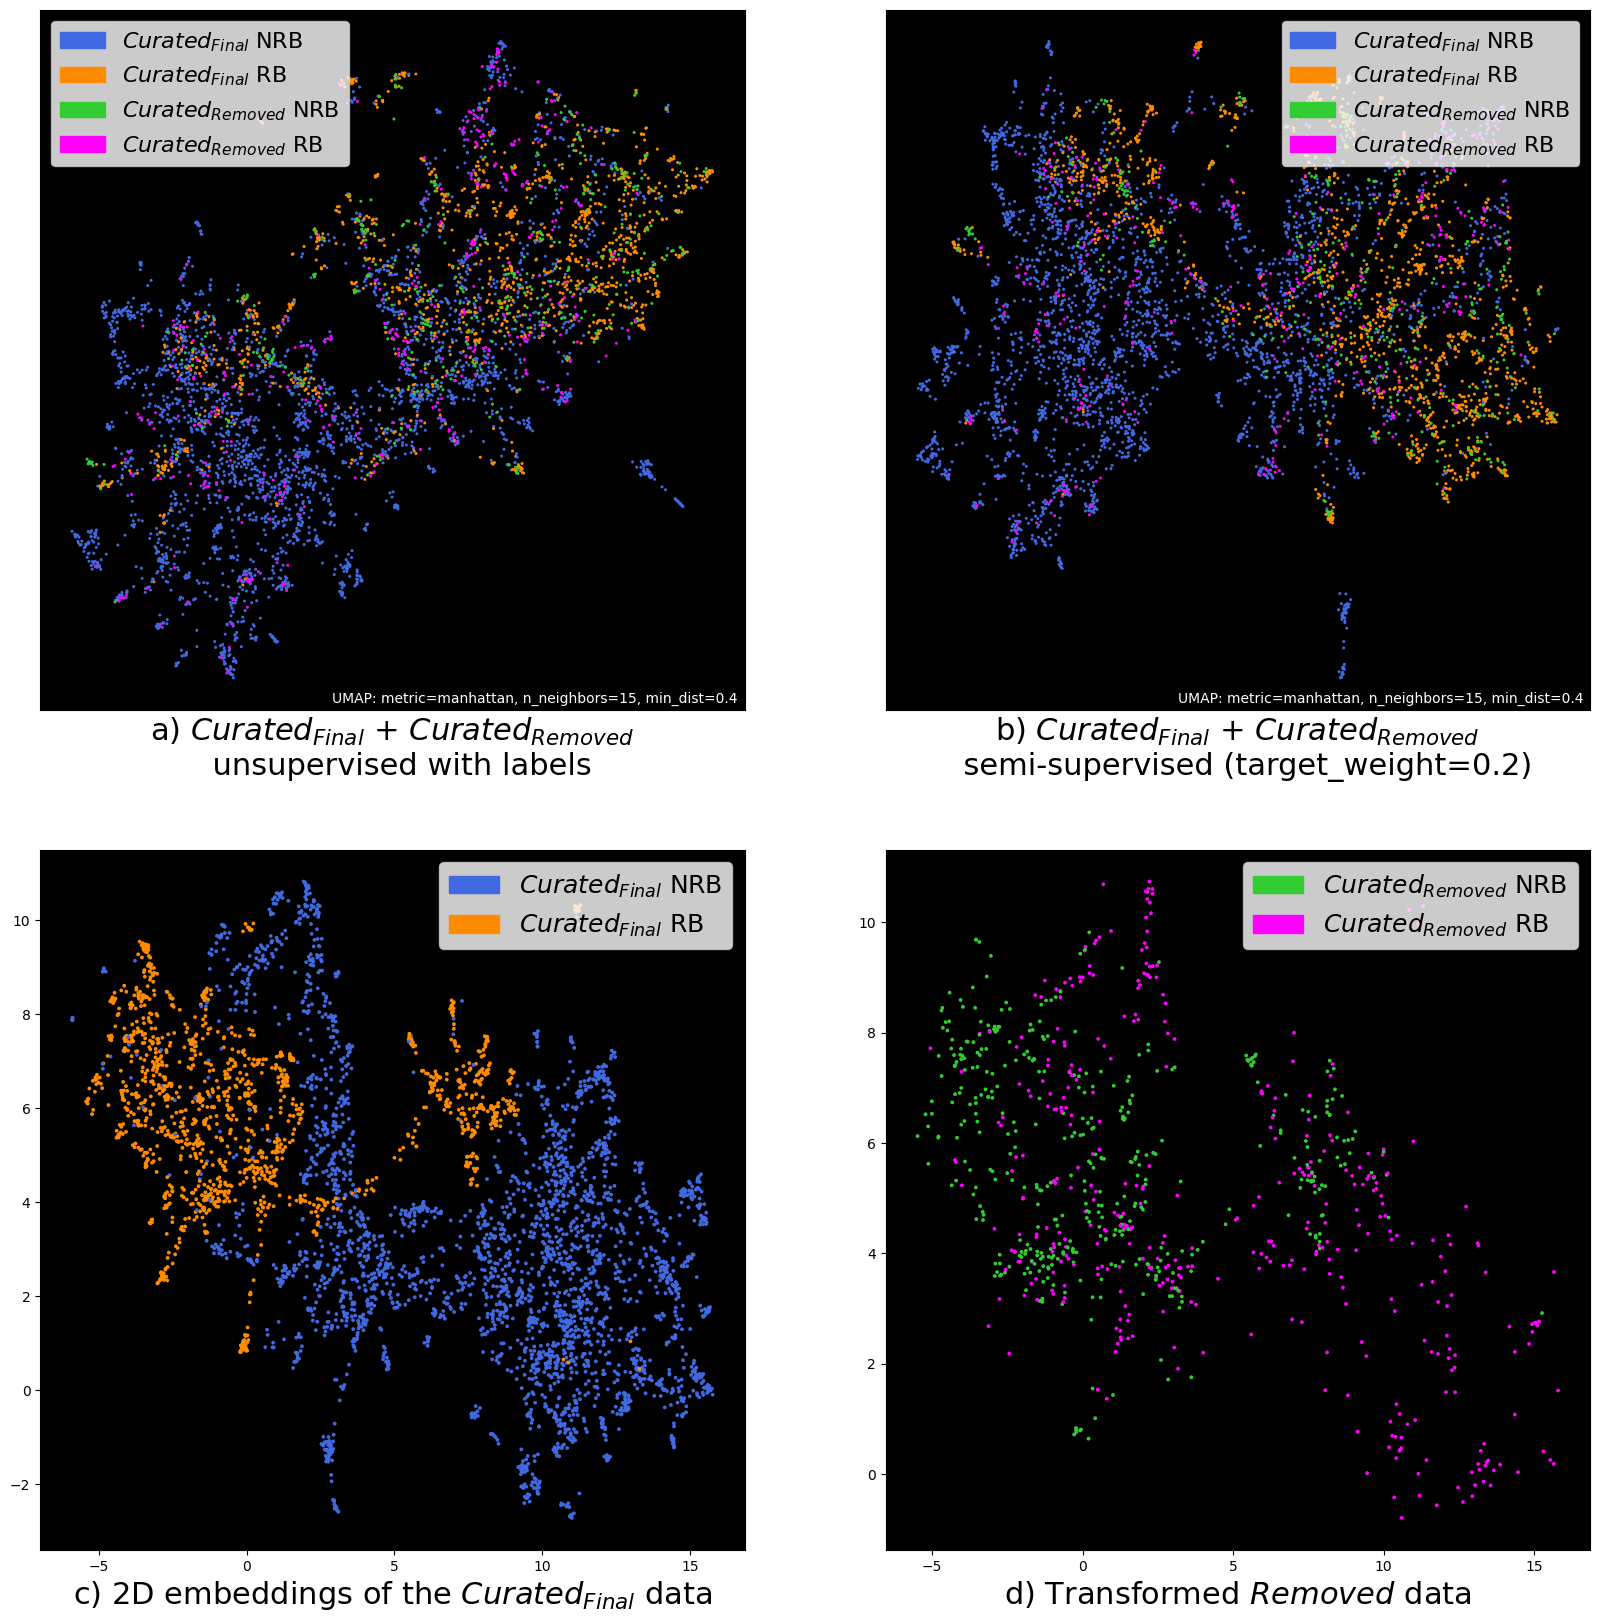

In [ ]:
create_plot_umap_different_features(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
    fp_type="rdk"
)

[0 1 2 3]
[-1  0  1]


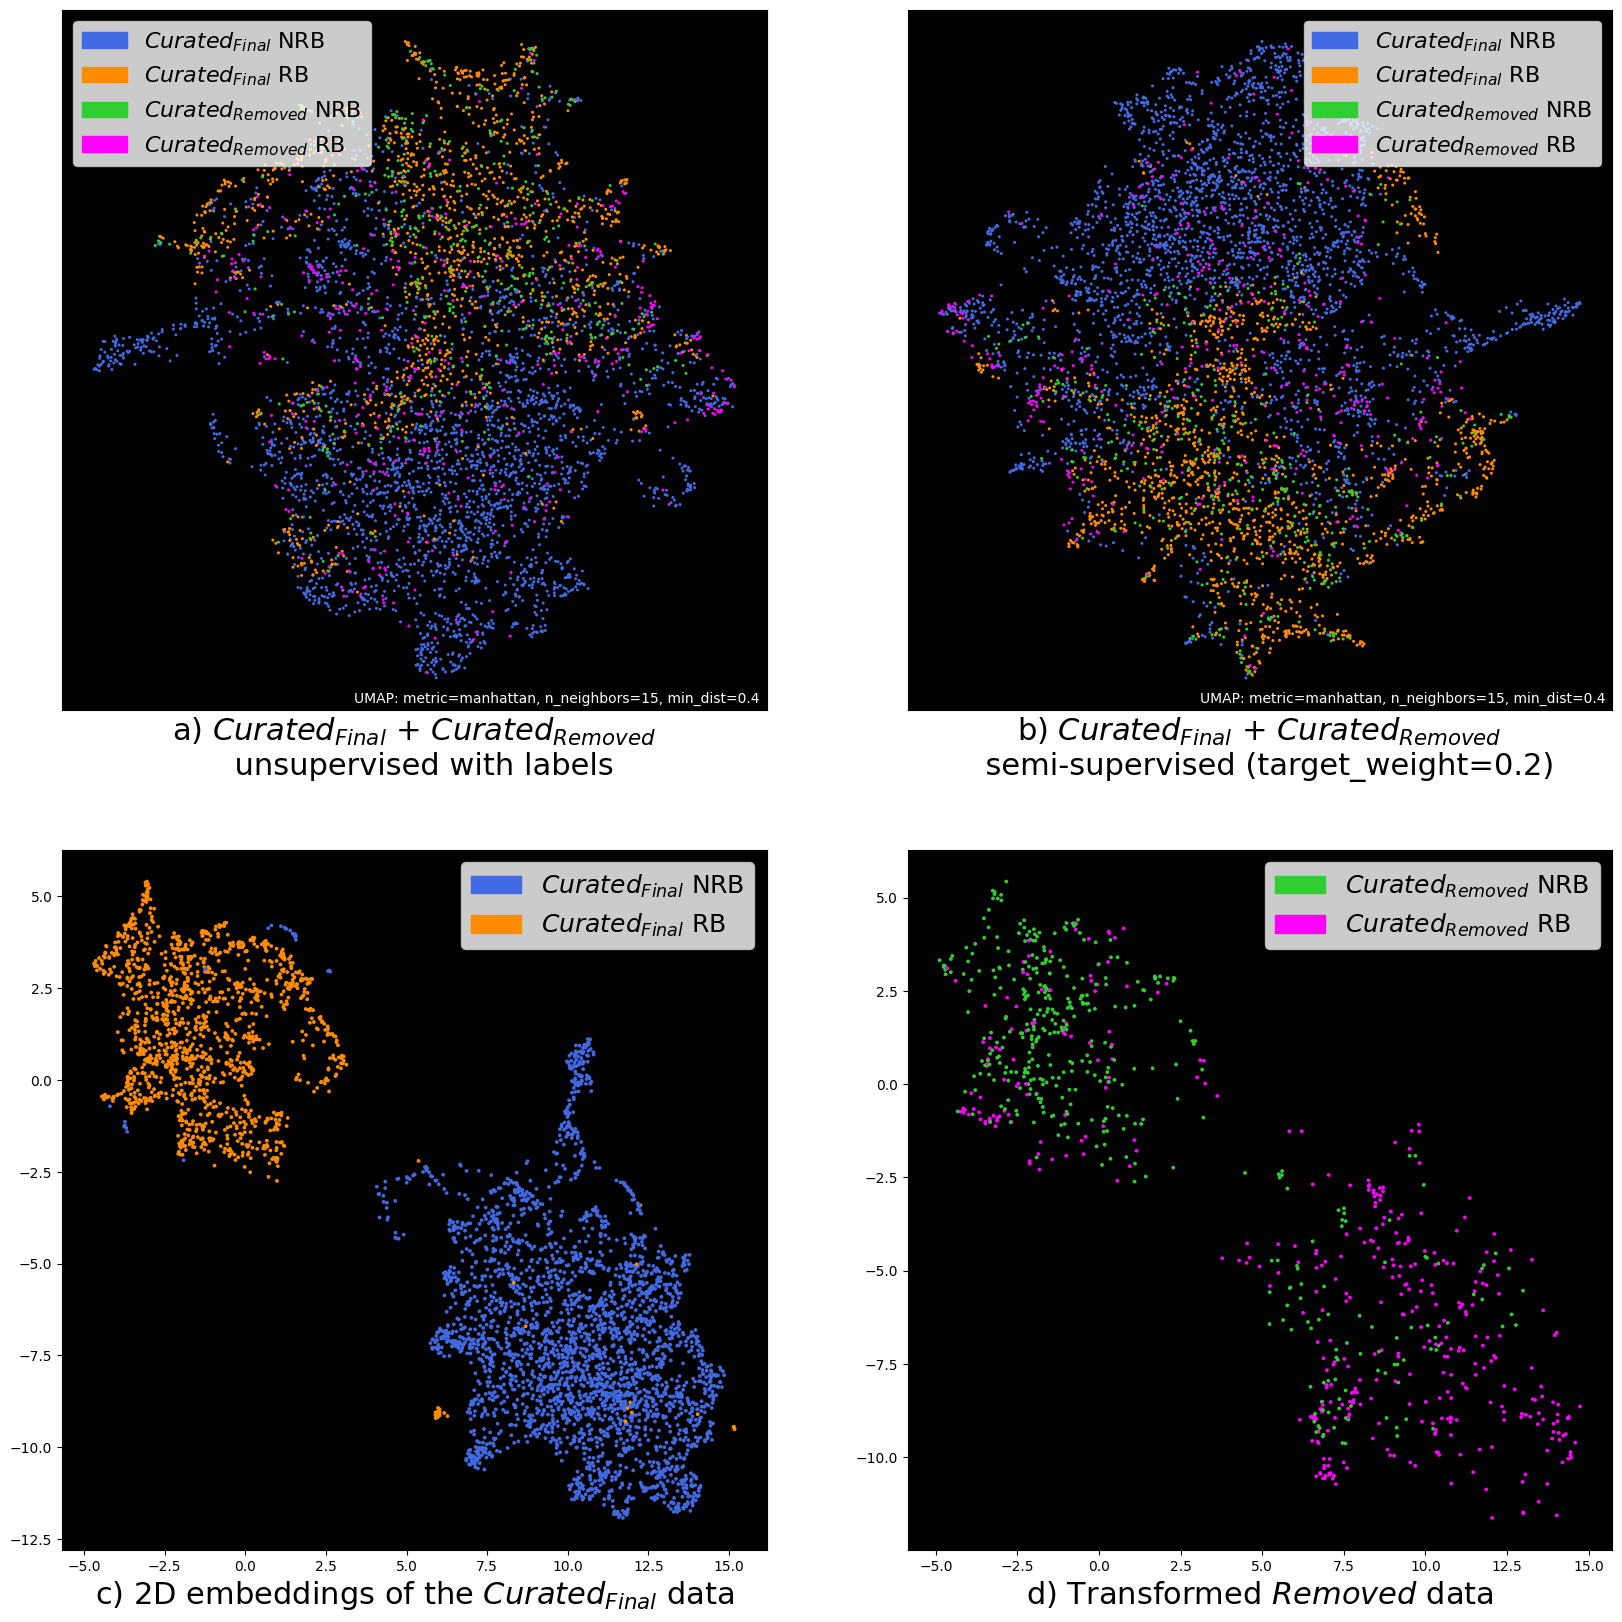

In [ ]:
create_plot_umap_different_features(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    target_weight=0.2, 
    metric="manhattan", 
    random_state=42,
    fp_type="molformer"
)

## Semi-supervised depending on weight

In [ ]:
def create_dfs_from_final_and_removed(df_final: pd.DataFrame, df_removed: pd.DataFrame, final: bool, fp_type: str) -> Tuple[
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
    pd.DataFrame, 
]:
    def convert_to_rdk_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        # calculate 2048 bit RDK fingerprint
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [Chem.RDKFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
        fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
        fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
        df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
        return df

    def convert_to_pubchem_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
        # calculate 881 bit PubChem fingerprint
        def get_pubchem_fp_padel(row) -> np.ndarray:
            smiles = row["smiles"]
            try:
                fingerprint_dict = from_smiles(smiles, fingerprints=True, descriptors=False)
            except: 
                print("Error when retrieving PubChem FP for SMILES ", smiles)
                return None
            fp = [int(bit) for bit in fingerprint_dict.values()]
            return fp
        
        df["fingerprint"] = df.progress_apply(get_pubchem_fp_padel, axis=1).to_list()
        df = df[df["fingerprint"] != None]
        return df

    if fp_type=="rdk":
        size = 2048
        df_final = convert_to_rdk_fingerprints(df=df_final)
        df_removed = convert_to_rdk_fingerprints(df=df_removed)
    elif fp_type=="maccs":
        size = 167
        df_final = convert_to_maccs_fingerprints(df=df_final)
        df_removed = convert_to_maccs_fingerprints(df=df_removed)
    elif fp_type=="pubchem":
        size = 881
        new = False # TODO
        if new:
            df_final = convert_to_pubchem_fingerprints(df=df_final)
            df_final.to_csv("datasets/different_features/df_final_pubchem_fingerprints.csv")
            df_removed = convert_to_pubchem_fingerprints(df=df_removed)
            df_removed.to_csv("datasets/different_features/df_removed_pubchem_fingerprints.csv")
        else:
            df_final = pd.read_csv("datasets/different_features/df_final_pubchem_fingerprints.csv", index_col=0)
            df_final = df_final.dropna(subset=['fingerprint'], how='any', ignore_index=True)
            df_final['fingerprint'] = df_final['fingerprint'].apply(lambda x: [int(val) if val != 'nan' else np.nan for val in str(x).strip('[]').split()])

            df_removed = pd.read_csv("datasets/different_features/df_removed_pubchem_fingerprints.csv", index_col=0)
            df_removed = df_removed.dropna(subset=['fingerprint'], how='any', ignore_index=True)
            df_removed['fingerprint'] = df_removed['fingerprint'].apply(lambda x: [int(val) if val != 'nan' else np.nan for val in str(x).strip('[]').split()])


    elif fp_type=="molformer":
        size = 768
        df_final = pd.read_csv("datasets/different_features/df_final_molformer_embeddings.csv", index_col=0)
        df_final['fingerprint'] = df_final['fingerprint'].apply(eval)
        df_removed = pd.read_csv("datasets/different_features/df_removed_molformer_embeddings.csv", index_col=0)
        df_removed['fingerprint'] = df_removed['fingerprint'].apply(eval)
    
    if final: 
        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"
    else: 
        curated = "$Curated_{BIOWIN}$"
        removed = "$Curated_{Problematic}$"

    cols = [*range(0, size, 1)] 
    df_final_fp = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)
    # Create scs labeled with removed and kept
    df_final_fp["label"] = curated
    df_removed_fp["label"] = removed
    df_scs_removed_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_removed_labels.reset_index(inplace=True, drop=True)
    df_scs_removed_labels["label_str"] = df_scs_removed_labels['label']

    # Create scs labeled with two labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels.reset_index(inplace=True, drop=True)
    df_scs_two_labels["label_str"] = df_scs_two_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # Create scs labeled with four labels: RB and NRB
    df_final_fp["label"] = df_final["label"]
    df_removed_fp["label"] = df_removed['label'] + 2
    df_scs_four_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_four_labels.reset_index(inplace=True, drop=True)
    df_scs_four_labels["label_str"] = df_scs_four_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB", 2: f"{removed} NRB", 3: f"{removed} RB"})

    # Create scs labeled with two labels four colors
    df_removed_fp["label"] = df_removed['label']
    df_scs_two_labels_four_colors = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_two_labels_four_colors.reset_index(inplace=True, drop=True)
    df_scs_two_labels_four_colors["label_str"] = df_scs_four_labels['label_str']

    # Create final labeled with RB and NRB
    df_final_fp_labeled = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
    df_final_fp_labeled["label"] = df_final["label"]
    df_final_fp_labeled["label_str"] = df_final_fp_labeled['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # semisupervised
    df_removed_fp["label"] = -1 # TODO
    df_scs_semi_supervised = pd.concat([df_final_fp, df_removed_fp], axis=0)
    df_scs_semi_supervised.reset_index(inplace=True, drop=True)
    df_scs_semi_supervised["label_str"] = df_scs_four_labels['label_str']

    # final 
    df_final_data = df_final_fp.copy()
    df_final_data["label_str"] = df_final_data['label'].map({0: f"{curated} NRB", 1: f"{curated} RB"})

    # removed
    df_removed_data = df_removed_fp.copy()
    df_removed_data["label"] = df_removed["label"]
    df_removed_data["label_str"] = df_removed_data['label'].map({0: f"{removed} NRB", 1: f"{removed} RB"})

    return df_final_data, df_removed_data, df_scs_removed_labels, df_scs_two_labels, df_scs_four_labels, df_scs_two_labels_four_colors, df_final_fp_labeled, df_scs_semi_supervised



def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
    number_of_labels: List[int],
) -> None:

    fig, axs = plt.subplots(2, 2, figsize=(20, 20)) #(Suplots: rows, cols -> 3, 2), figsize = (20,30)

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]

        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"

        if ('NRB' in label[0]) | ('RB' in label[0]):
            color_key={
                f"{curated} NRB": 'royalblue', 
                f"{removed} NRB": 'limegreen', 
                f"{curated} RB": 'darkorange', 
                f"{removed} RB": 'fuchsia'} 
        else: 
            color_key={
                curated: 'green', 
                removed: 'gold'}

        umap.plot.points(
            umap_object=manifolds[i], 
            labels=label, 
            color_key=color_key,
            background='black',
            ax=ax,
        ) 
        ax.set_xlabel(titles[i], fontsize=22)
        nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
        rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
        if number_of_labels[i] == 4:
            nrb_r = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
            rb_r = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
            ax.legend(loc=legend_loc[i], handles=[nrb, rb, nrb_r, rb_r], fontsize=16)
        elif ('NRB' not in label[0]) & ('RB' not in label[0]):
            cb = mpatches.Patch(color='green', label=curated)
            cr = mpatches.Patch(color='gold', label=removed)
            ax.legend(loc=legend_loc[i], handles=[cb, cr], fontsize=16)
        else:
            ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=16)

def create_plot_umap_test_semi_supervised(
    n_components, 
    n_neighbors, 
    min_dist, 
    metric, 
    random_state,
    fp_type,
) -> None:

    # Final
    _, _, _, _, _, _, _, df_scs_semi_supervised_final = create_dfs_for_umap_different_features(fp_type)


    manifold_semi_supervised1, y_str_semi_supervised1 = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=0.1,
        supervised=True,
    )
    manifold_semi_supervised2, y_str_semi_supervised2 = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=0.2,
        supervised=True,
    )
    manifold_semi_supervised4, y_str_semi_supervised4 = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=0.4,
        supervised=True,
    )
    manifold_semi_supervised6, y_str_semi_supervised6 = create_manifold(
        df=df_scs_semi_supervised_final, 
        n_components=n_components,
        n_neighbors=n_neighbors, 
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
        target_weight=0.6,
        supervised=True,
    )


    # Create plot
    manifolds = [
        manifold_semi_supervised1, 
        manifold_semi_supervised2,
        manifold_semi_supervised4,
        manifold_semi_supervised6,
    ]
    y_strs = [
        y_str_semi_supervised1,
        y_str_semi_supervised2,
        y_str_semi_supervised4,
        y_str_semi_supervised6,
    ]

    titles = [
        'a) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised (target_weight=0.1)',
        'b) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised (target_weight=0.2)',
        'c) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised (target_weight=0.4)',
        'd) $Curated_{Final}$ + $Curated_{Removed}$ \n  semi-supervised (target_weight=0.6)',
    ]
    legend_loc = [
        'upper right',
        'upper right',
        'upper left',
        'upper left',
    ]
    number_of_labels = [4, 4, 4, 4]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
        number_of_labels=number_of_labels,
    )


[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]


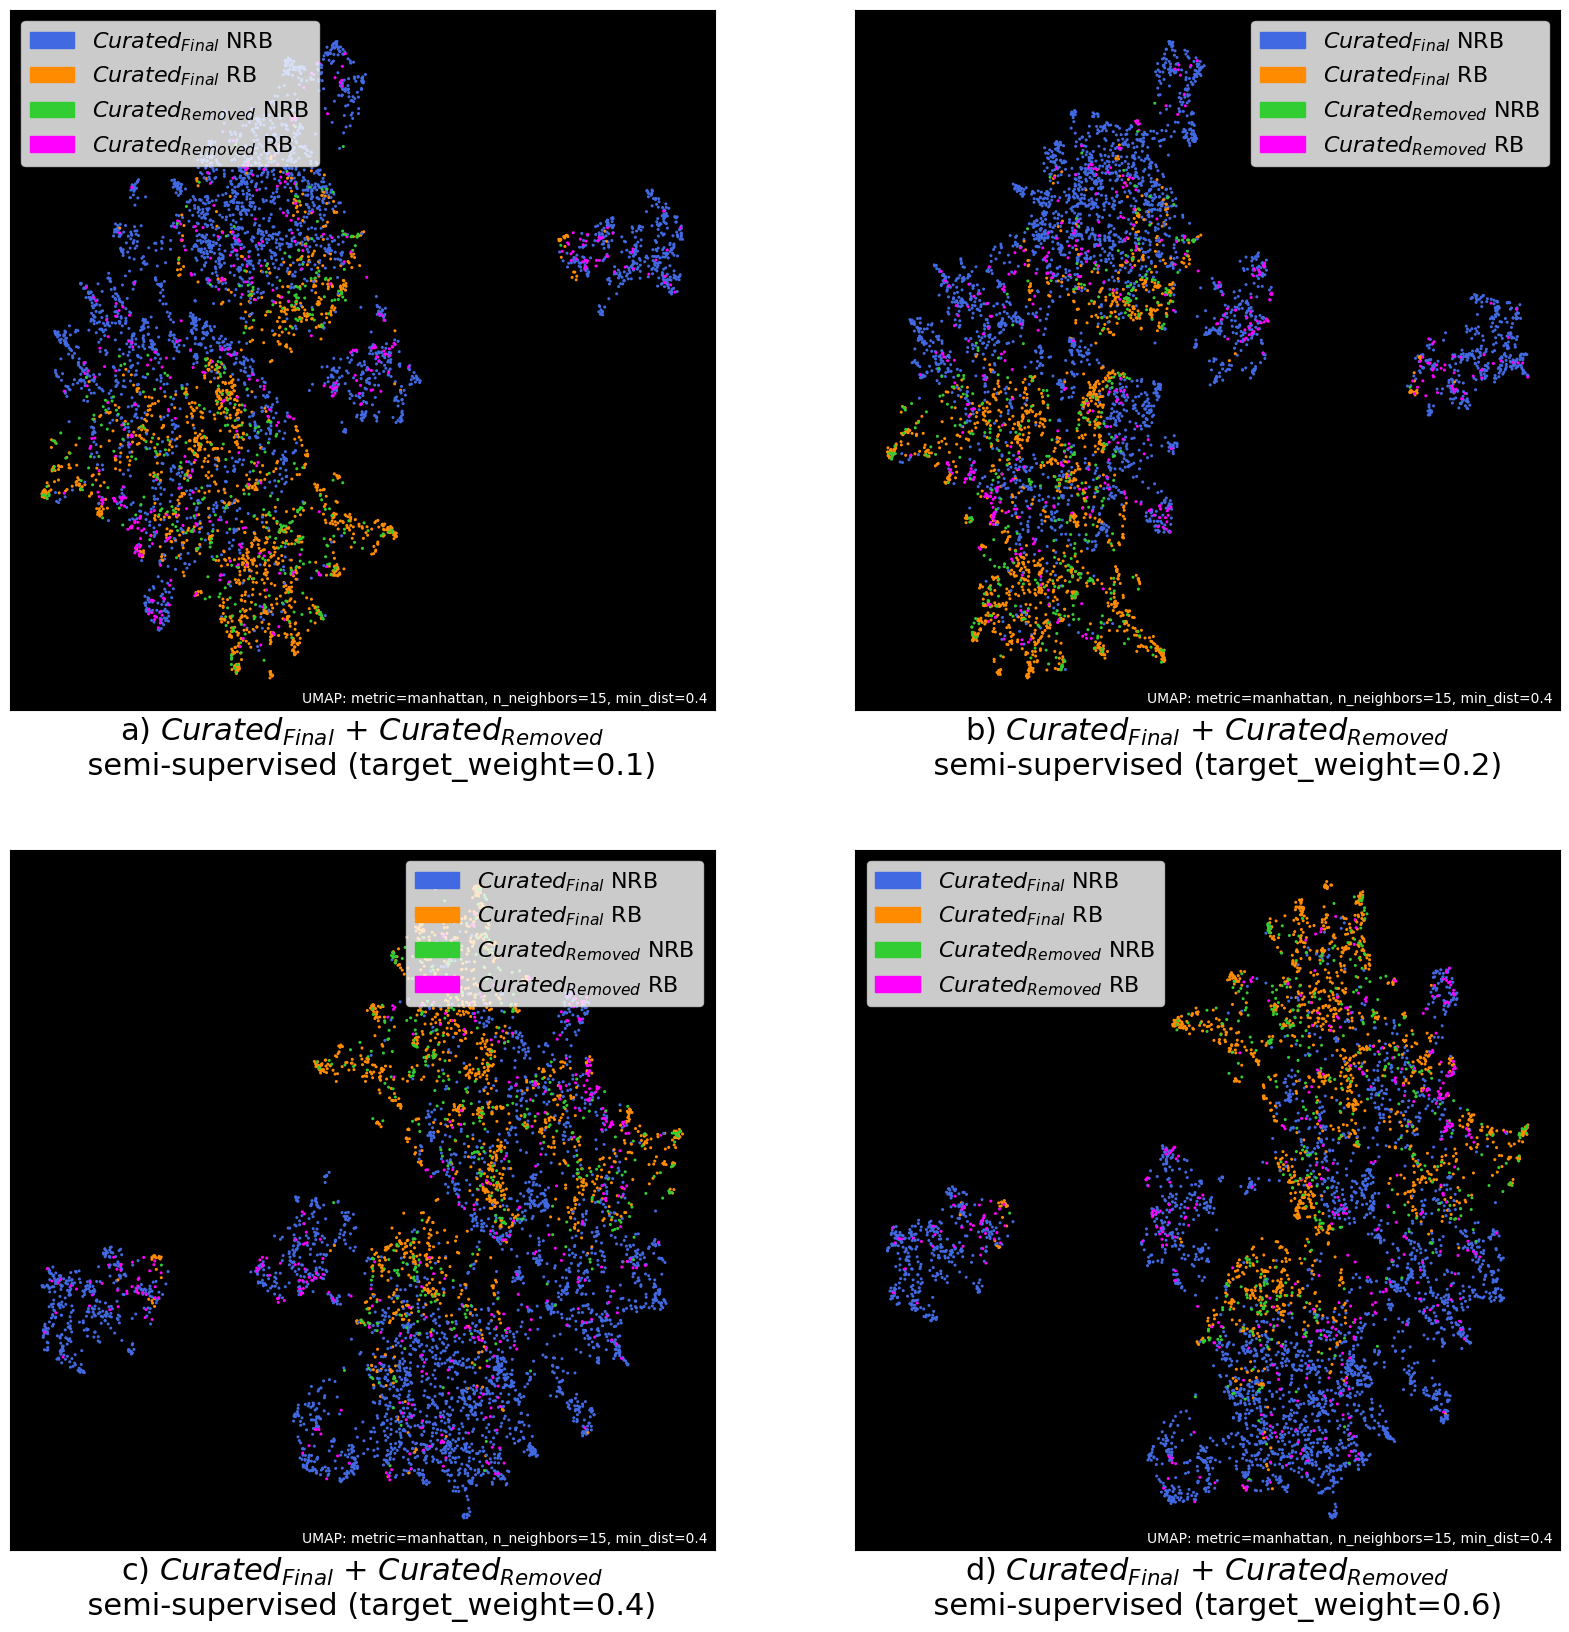

In [ ]:
create_plot_umap_test_semi_supervised(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    metric="manhattan", 
    random_state=42,
    fp_type="maccs"
)

## Fit transform based on weight

In [59]:
def create_plot(
    manifolds: List[umap.umap_.UMAP], 
    y_strs: List[np.ndarray], 
    titles: List[str], 
    legend_loc: List[str], 
) -> None:

    fig, axs = plt.subplots(2, 2, figsize=(20, 20)) #(Suplots: rows, cols -> 3, 2), figsize = (20,30)

    for i, ax in enumerate(axs.flatten()):
        label=y_strs[i]

        curated = "$Curated_{Final}$"
        removed = "$Curated_{Removed}$"


        for indx in range(len(label)):
            if label[indx] == f"{curated} NRB":
                label[indx] = 'royalblue'
            elif label[indx] == f"{curated} RB":
                label[indx] = 'darkorange'
            elif label[indx] == f"{removed} NRB":
                label[indx] = 'limegreen'
            elif label[indx] == f"{removed} RB":
                label[indx] = 'fuchsia'
        
        manifolds_embedding = manifolds[i]
        ax.scatter(manifolds_embedding[:, 0], manifolds_embedding[:, 1], s=3, c=label)
        ax.set_xlabel(titles[i], fontsize=22)
        ax.set_facecolor('black')
        if '$Curated_{Final}$' in titles[i]:
            nrb = mpatches.Patch(color='royalblue', label=f"{curated} NRB")
            rb = mpatches.Patch(color='darkorange', label=f"{curated} RB")
            ax.legend(loc=legend_loc[i], handles=[nrb, rb], fontsize=18) #, title="Classes"
        else: 
            nrbr = mpatches.Patch(color='limegreen', label=f"{removed} NRB")
            rbr = mpatches.Patch(color='fuchsia', label=f"{removed} RB")
            ax.legend(loc=legend_loc[i], handles=[nrbr, rbr], fontsize=18) #, title="Classes"



def create_plot_umap_test_fit_transform(
    n_components, 
    n_neighbors, 
    min_dist, 
    metric, 
    random_state,
    fp_type,
) -> None:

    # Final
    df_final, df_removed, _, _, _, _, _, _ = create_dfs_for_umap_different_features(fp_type)

    # Fit final and then transform removed data
    x_final, y_final, y_final_str = df_final.drop(["label", "label_str"], axis=1), df_final[["label"]].values.flatten(), df_final[["label_str"]].values.flatten()
    
    manifold_final2 = umap.UMAP(
        n_components=n_components, 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric=metric, 
        random_state=random_state, 
        n_jobs=1,
        target_weight=0.2,
    ).fit(x_final, y_final)
    # Transform removed 
    x_removed2, _, y_removed_str2 = df_removed.drop(["label", "label_str"], axis=1), df_removed[["label"]].values.flatten(), df_removed[["label_str"]].values.flatten()
    manifold_fit_transform2 = manifold_final2.transform(x_removed2)

    manifold_final5 = umap.UMAP(
        n_components=n_components, 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric=metric, 
        random_state=random_state, 
        n_jobs=1,
        target_weight=0.5,
    ).fit(x_final, y_final)
    # Transform removed 
    x_removed5, _, y_removed_str5 = df_removed.drop(["label", "label_str"], axis=1), df_removed[["label"]].values.flatten(), df_removed[["label_str"]].values.flatten()
    manifold_fit_transform5 = manifold_final5.transform(x_removed5)


    # Create plot
    manifolds = [
        manifold_final2.embedding_,
        manifold_fit_transform2,
        manifold_final5.embedding_,
        manifold_fit_transform5,
    ]
    y_strs = [
        y_final_str,
        y_removed_str2,
        y_final_str,
        y_removed_str5,
    ]

    titles = [
        'a) 2D embeddings of the $Curated_{Final}$ data \n (target_weight=0.2)',
        'b) Transformed $Removed$ data \n (target_weight=0.2)',
        'c) 2D embeddings of the $Curated_{Final}$ data \n (target_weight=0.5)',
        'd) Transformed $Removed$ data \n (target_weight=0.5)',
    ]
    legend_loc = [
        'upper left',
        'upper left',
        'lower left',
        'lower left',
    ]

    create_plot(
        manifolds=manifolds, 
        y_strs=y_strs, 
        titles=titles, 
        legend_loc=legend_loc, 
    )


/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/paulina_koerner/Desktop/MasterThesis/master_thesis_env/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


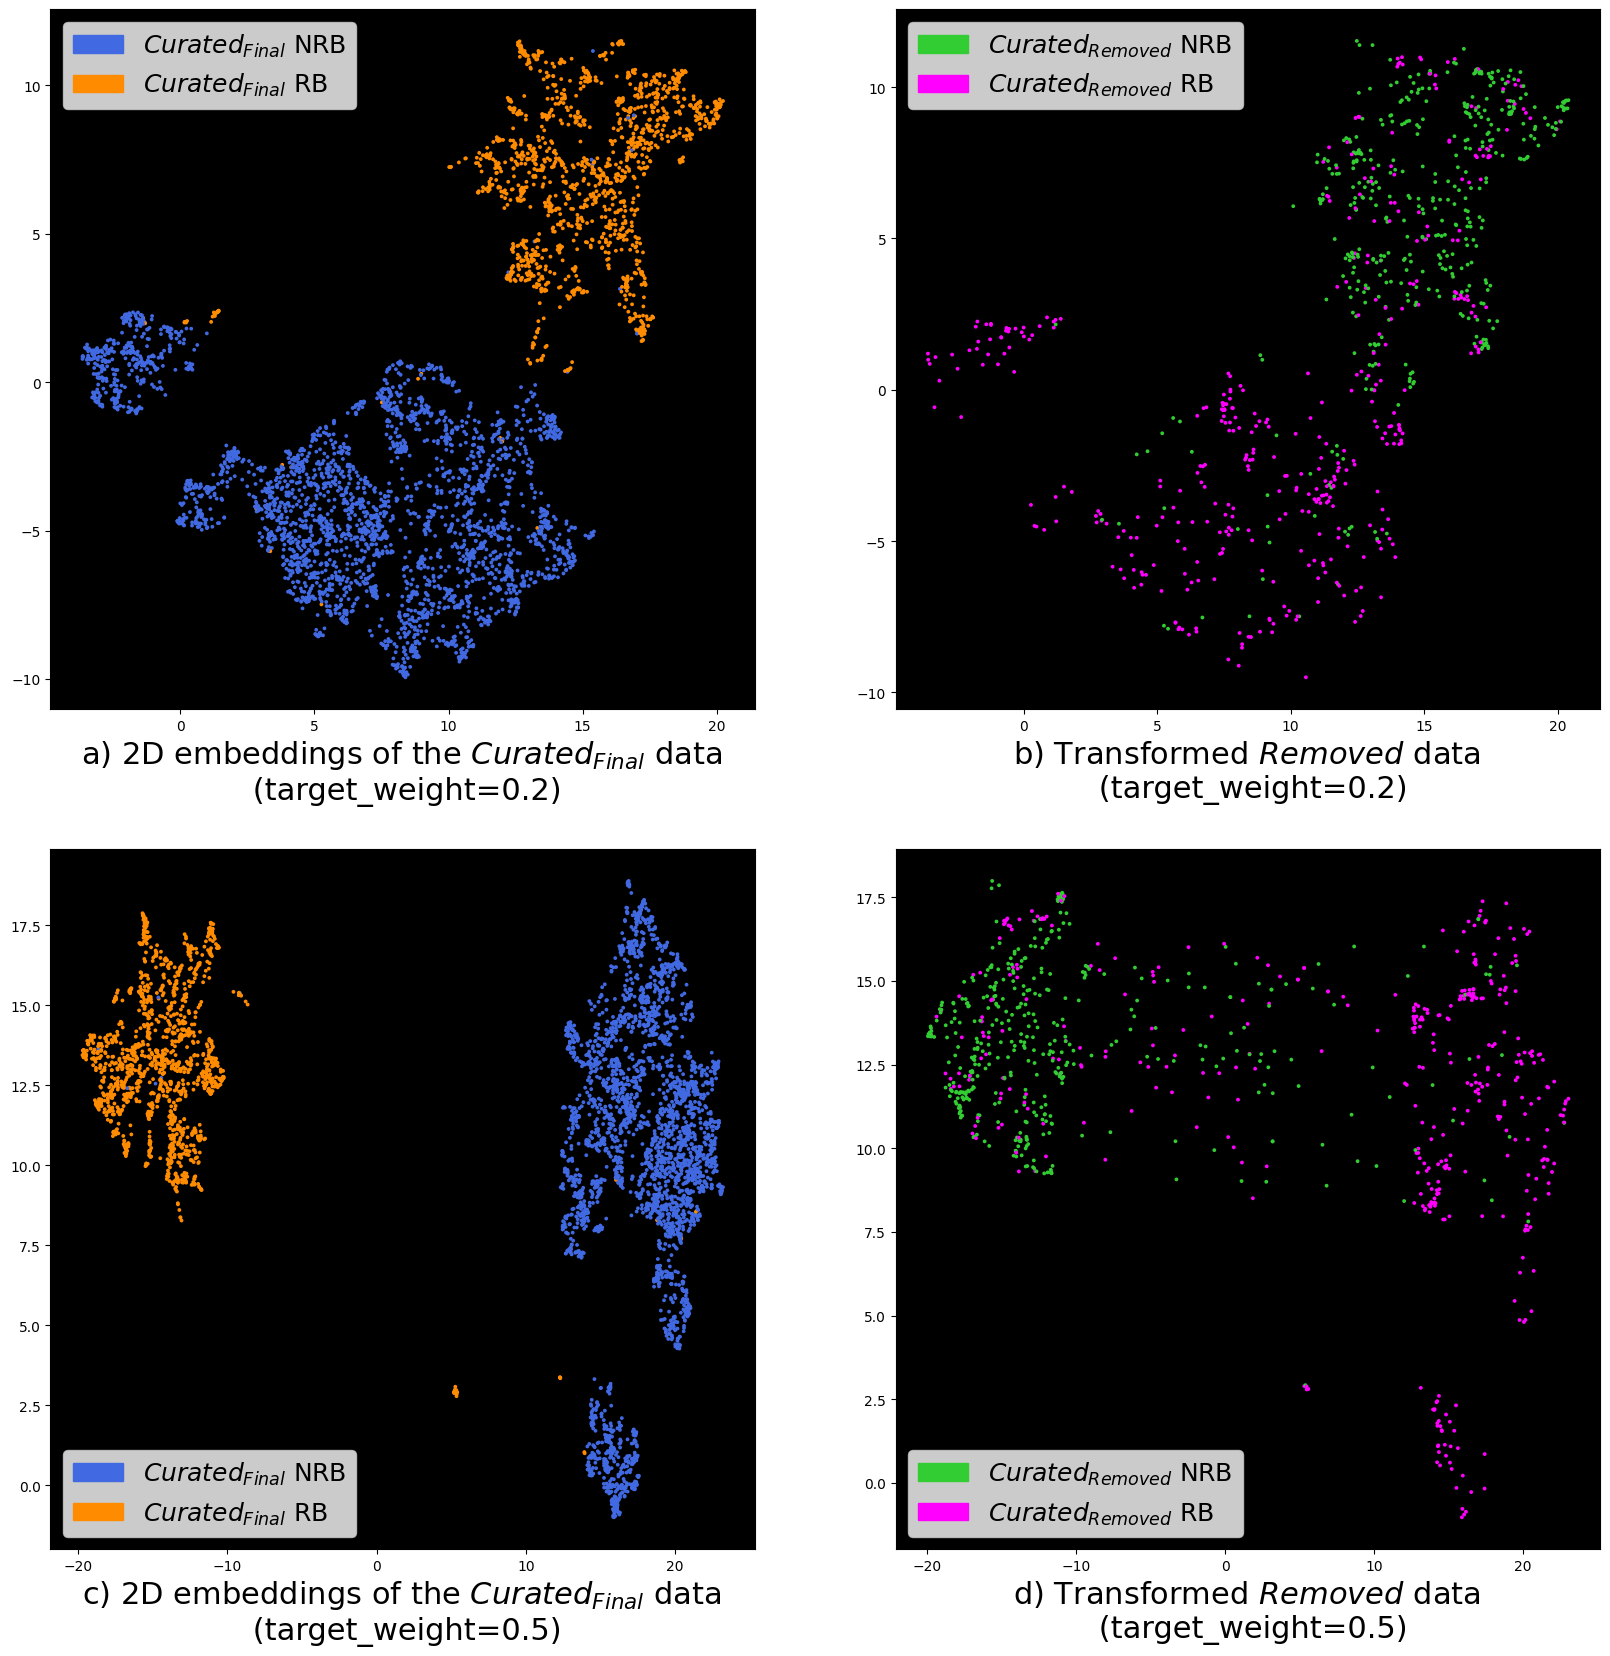

In [60]:
create_plot_umap_test_fit_transform(
    n_components=2, 
    n_neighbors=15, 
    min_dist=0.4, 
    metric="manhattan", 
    random_state=42,
    fp_type="maccs"
)

## PaCMAP


In [16]:
import pacmap
import numpy as np
import matplotlib.pyplot as plt

###################################################################
df_final = pd.read_csv("datasets/improved_data/class_improved_env_biowin_both_readded.csv", index_col=0)
df_final = df_final[['cas', 'smiles','inchi_from_smiles', 'label', 'linear_label',
    'non_linear_label', 'miti_linear_label', 'miti_non_linear_label',
    'prediction_class']]
df_final.reset_index(inplace=True, drop=True)
df_removed = pd.read_csv("datasets/improved_data/class_improved_env_biowin_both_removed_predicted.csv", index_col=0)
df_removed = df_removed[df_removed["label"] != df_removed["prediction_class"]]
df_removed.reset_index(inplace=True, drop=True)

def convert_to_maccs_fingerprints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    mols = [AllChem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    fp_vecs = [GetMACCSKeysFingerprint(mol) for mol in mols]
    fp_arrays = [np.frombuffer(fp_vec.ToBitString().encode(), 'u1') - ord('0') for fp_vec in fp_vecs]
    df["fingerprint"] = [fp_array.tolist() for fp_array in fp_arrays]
    return df

df_final = convert_to_maccs_fingerprints(df=df_final)
df_removed = convert_to_maccs_fingerprints(df=df_removed)

cols = [*range(0, 167, 1)]

df_final_fp = pd.DataFrame(df_final.fingerprint.tolist(), columns=cols)
df_final_fp["label"] = df_final["label"]
df_removed_fp = pd.DataFrame(df_removed.fingerprint.tolist(), columns=cols)

# final 
df_final_data = df_final_fp.copy()
df_final_data["label_str"] = df_final_data['label'].map({0: "NRB", 1: "RB"})

# removed
df_removed_data = df_removed_fp.copy()
df_removed_data["label"] = df_removed["label"]
df_removed_data["label_str"] = df_removed_data['label'].map({0: "NRB removed", 1: "RB removed"})

curated = "$Curated_{Final}$"
removed = "$Curated_{Removed}$"

# Create scs labeled with four labels: RB and NRB
df_final_fp["label"] = df_final["label"]
df_removed_fp["label"] = df_removed['label'] + 2
df_scs_four_labels = pd.concat([df_final_fp, df_removed_fp], axis=0)
df_scs_four_labels["label_str"] = df_scs_four_labels['label'].map({0: f"{curated} NRB", 1: f"{curated} RB", 2: f"{removed} NRB", 3: f"{removed} RB"})

###################################################################

y_str = df_scs_four_labels["label_str"].to_numpy()
y = df_scs_four_labels["label"].to_numpy()
X = df_scs_four_labels.drop(columns=["label_str", "label"]).to_numpy()

# initializing the pacmap instance
# Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(X, init="pca")

# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Spectral", c=y, s=0.6)

ModuleNotFoundError: No module named 'pacmap'